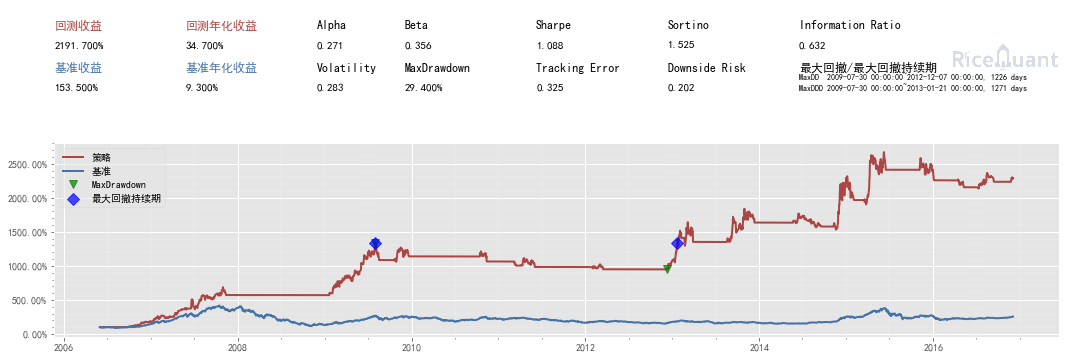

In [2]:
from rqalpha import run_code

code = """
import numpy as np
import talib as ta
import pandas as pd
import os
import rqalpha
from rqalpha.api import *

def Second_Breakout(high_array, low_array, period):
    high = ta.MAX(high_array, period)
    low = ta.MIN(low_array, period)
    return {period: high, -period: low}

def Second_Break_DF(context, high, low):
    position_dict = {'high': high, 'low':low}
    for i in context.period:
        position_dict.update(Second_Breakout(high, low, i))
    DF = pd.DataFrame(position_dict).dropna()
    return DF

def Second_Break_Indicator(context, series):
    low = 0
    high = 0
    is_high = 1
    is_low = 1
    for i in context.period:
        if is_low:
            if series['low'] <= series[-i]:
                low = -i
            else:
                is_low = 0
                if is_high == 0:
                    return low
        if is_high:
            if series['high'] >= series[i]:
                high = i
            else:
                is_high = 0
                if is_low == 0:
                    return high

    if is_high:
        return high
    elif is_low:
        return low

def break_day(context, df):
    return [Second_Break_Indicator(context, row) for name, row in df.iterrows()]

def init(context):
    context.s1 = "000001.XSHE"
    context.period = np.array(range(10, 81, 10))
    context.stoplossmultipler= 0.99
    context.takepofitmultipler= 5


def handle_bar(context, bar_dict):
    high = history_bars(context.s1, 101, '1d', 'high')
    print high
    low = history_bars(context.s1, 101, '1d', 'low')
    close = history_bars(context.s1, 62, '1d', 'close')
    # if len(high)>101:
    EMA = ta.EMA(close, 50)
    DF =  Second_Break_DF(context, high, low)
    bd = break_day(context, DF)
    shares = context.portfolio.cash/bar_dict[context.s1].close
    if bar_dict[context.s1].close < EMA[-2]:
        order_target_value(context.s1, 0)

    if bd[-1]>30 and bd[-2]<30 and max(bd)==bd[-1]:
        order_shares(context.s1, shares)
    """

config = {
  "base": {
    "start_date": "2006-06-01",
    "end_date": "2016-12-01",
    "securities": ['stock'],
    "stock_starting_cash": 100000,
    "benchmark": "000300.XSHG"
#     "strategy_file_path": os.path.abspath(__file__)
  },
  "extra": {
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

run_code(code, config)